## 深度循环神经网络

到⽬前为⽌，我们只讨论了具有⼀个单向隐藏层的循环神经⽹络。其中，隐变量和观测值与具体的函数形式
的交互⽅式是相当随意的。只要交互类型建模具有⾜够的灵活性，这就不是⼀个⼤问题。然⽽，对⼀个单层
来说，这可能具有相当的挑战性。之前在线性模型中，我们通过添加更多的层来解决这个问题。⽽在循环神
经⽹络中，我们⾸先需要确定如何添加更多的层，以及在哪⾥添加额外的⾮线性，因此这个问题有点棘⼿。

事实上，我们可以将多层循环神经⽹络堆叠在⼀起，通过对⼏个简单层的组合，产⽣了⼀个灵活的机制。特
别是，数据可能与不同层的堆叠有关。例如，我们可能希望保持有关⾦融市场状况（熊市或⽜市）的宏观数
据可⽤，⽽微观数据只记录较短期的时间动态。

图9.3.1描述了⼀个具有L个隐藏层的深度循环神经⽹络，每个隐状态都连续地传递到当前层的下⼀个时间步
和下⼀层的当前时间步。
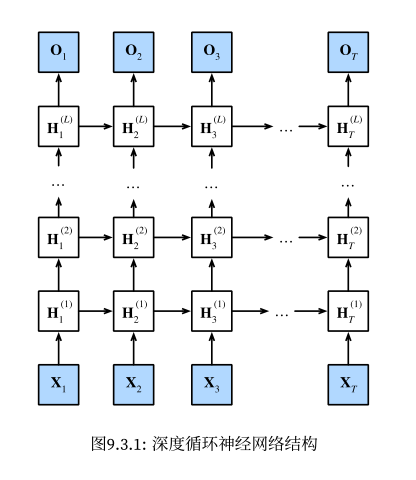
### 函数依赖关系
我们可以将深度架构中的函数依赖关系形式化，这个架构是由 图9.3.1中描述了L个隐藏层构成。后续的讨论
主要集中在经典的循环神经⽹络模型上，但是这些讨论也适应于其他序列模型。

假设在时间步t有⼀个⼩批量的输⼊数据 X t ∈ R n×d （样本数：n，每个样本中的输⼊数：d）。同时，将l th 隐
藏层（l = 1,...,L）的隐状态设为H (l)
t
∈ R n×h （隐藏单元数：h），输出层变量设为O t ∈ R n×q （输出数：q）。
设置H (0)
t
= X t ，第l个隐藏层的隐状态使⽤激活函数ϕ l ，则：
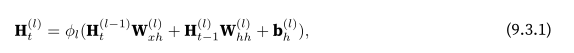
其中，权重W (l)
xh
∈ R h×h ，W (l)
hh
∈ R h×h 和偏置b (l)
h
∈ R 1×h 都是第l个隐藏层的模型参数。

最后，输出层的计算仅基于第l个隐藏层最终的隐状态：
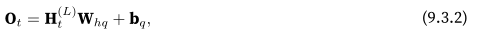
其中，权重W hq ∈ R h×q 和偏置b q ∈ R 1×q 都是输出层的模型参数。

与多层感知机⼀样，隐藏层数⽬L和隐藏单元数⽬h都是超参数。也就是说，它们可以由我们调整的。另外，
⽤⻔控循环单元或⻓短期记忆⽹络的隐状态来代替 (9.3.1)中的隐状态进⾏计算，可以很容易地得到深度⻔控
循环神经⽹络或深度⻓短期记忆神经⽹络。

### 简洁实现
实现多层循环神经⽹络所需的许多逻辑细节在⾼级API中都是现成的。简单起⻅，我们仅⽰范使⽤此类内置
函数的实现⽅式。以⻓短期记忆⽹络模型为例，该代码与之前在 9.2节中使⽤的代码⾮常相似，实际上唯⼀
的区别是我们指定了层的数量，⽽不是使⽤单⼀层这个默认值。像往常⼀样，我们从加载数据集开始。

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

像选择超参数这类架构决策也跟 9.2节中的决策⾮常相似。因为我们有不同的词元，所以输⼊和输出都选择
相同数量，即vocab_size。隐藏单元的数量仍然是256。唯⼀的区别是，我们现在通过num_layers的值来设定
隐藏层数。

In [ ]:
vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
device = d2l.try_gpu()
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers)
model = d2l.RNNModel(lstm_layer, vocab_size)
model = model.to(device)

### 训练与预测
由于使⽤了⻓短期记忆⽹络模型来实例化两个层，因此训练速度被⼤⼤降低了。

In [ ]:
num_epochs, lr = 500, 2
d2l.train_ch8(model, train_iter, vocab, lr*1.0, num_epochs, device)

⼩结

    • 在深度循环神经⽹络中，隐状态的信息被传递到当前层的下⼀时间步和下⼀层的当前时间步。
    • 有许多不同⻛格的深度循环神经⽹络，如⻓短期记忆⽹络、⻔控循环单元、或经典循环神经⽹络。这些模型在深度学习框架的⾼级API中都有涵盖。
    • 总体⽽⾔，深度循环神经⽹络需要⼤量的调参（如学习率和修剪）来确保合适的收敛，模型的初始化也需要谨慎。

## 双向循环神经网络
在序列学习中，我们以往假设的⽬标是：在给定观测的情况下（例如，在时间序列的上下⽂中或在语⾔模型
的上下⽂中），对下⼀个输出进⾏建模。虽然这是⼀个典型情景，但不是唯⼀的。还可能发⽣什么其它的情况
呢？我们考虑以下三个在⽂本序列中填空的任务。

    • 我___。
    • 我___饿了。
    • 我___饿了，我可以吃半头猪。
根据可获得的信息量，我们可以⽤不同的词填空，如“很⾼兴”（”happy”）、“不”（”not”）和“⾮常”（”
very”）。很明显，每个短语的“下⽂”传达了重要信息（如果有的话），⽽这些信息关乎到选择哪个词来填
空，所以⽆法利⽤这⼀点的序列模型将在相关任务上表现不佳。例如，如果要做好命名实体识别（例如，识
别“Green”指的是“格林先⽣”还是绿⾊），不同⻓度的上下⽂范围重要性是相同的。为了获得⼀些解决问
题的灵感，让我们先迂回到概率图模型。
### 隐马尔可夫模型中的动态规划
这⼀⼩节是⽤来说明动态规划问题的，具体的技术细节对于理解深度学习模型并不重要，但它有助于我们思
考为什么要使⽤深度学习，以及为什么要选择特定的架构。

如果我们想⽤概率图模型来解决这个问题，可以设计⼀个隐变量模型：在任意时间步t，假设存在某个隐变量h t ，
通过概率P(x t | h t )控制我们观测到的x t 。此外，任何h t → h t+1 转移都是由⼀些状态转移概率P(h t+1 | h t )给
出。这个概率图模型就是⼀个隐⻢尔可夫模型（hidden Markov model，HMM），如 图9.4.1所⽰。
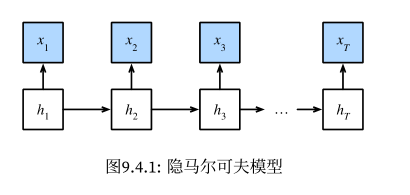
因此，对于有T个观测值的序列，我们在观测状态和隐状态上具有以下联合概率分布：
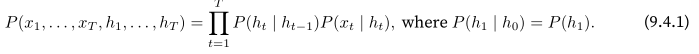
现在，假设我们观测到所有的x i ，除了x j ，并且我们的⽬标是计算P(x j | x −j )，其中x −j =
(x 1 ,...,x j−1 ,x j+1 ,...,x T )。由于P(x j | x −j )中没有隐变量，因此我们考虑对h 1 ,...,h T 选择构成的所有可能
的组合进⾏求和。如果任何h i 可以接受k个不同的值（有限的状态数），这意味着我们需要对k T 个项求和，这
个任务显然难于登天。幸运的是，有个巧妙的解决⽅案：动态规划（dynamic programming）。
要了解动态规划的⼯作⽅式，我们考虑对隐变量h 1 ,...,h T 的依次求和。根据 (9.4.1)，将得出：
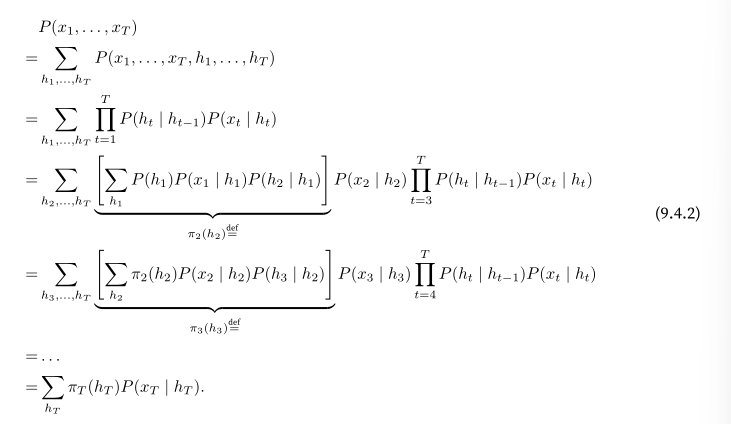
通常，我们将前向递归（forward recursion）写为：
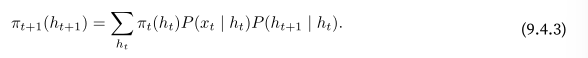
递归被初始化为π 1 (h 1 ) = P(h 1 )。符号简化，也可以写成π t+1 = f(π t ,x t )，其中f是⼀些可学习的函数。这看
起来就像我们在循环神经⽹络中讨论的隐变量模型中的更新⽅程。

与前向递归⼀样，我们也可以使⽤后向递归对同⼀组隐变量求和。这将得到：
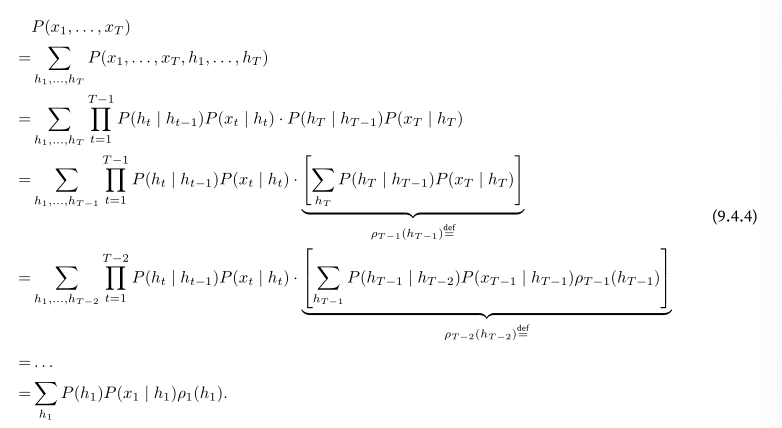
因此，我们可以将后向递归（backward recursion）写为：
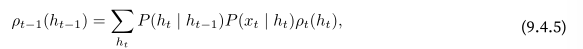
初始化ρ T (h T ) = 1。前向和后向递归都允许我们对T个隐变量在O(kT) （线性⽽不是指数）时间内
对(h 1 ,...,h T )的所有值求和。这是使⽤图模型进⾏概率推理的巨⼤好处之⼀。它也是通⽤消息传递算法 (Aji
and McEliece, 2000)的⼀个⾮常特殊的例⼦。结合前向和后向递归，我们能够计算
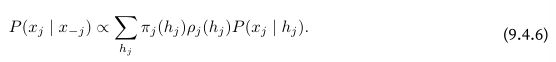
因为符号简化的需要，后向递归也可以写为ρ t−1 = g(ρ t ,x t )，其中g是⼀个可以学习的函数。同样，这看起来
⾮常像⼀个更新⽅程，只是不像我们在循环神经⽹络中看到的那样前向运算，⽽是后向计算。事实上，知道
未来数据何时可⽤对隐⻢尔可夫模型是有益的。信号处理学家将是否知道未来观测这两种情况区分为内插和
外推，有关更多详细信息，请参阅 (Doucet et al., 2001)。
### 双向模型
如果我们希望在循环神经⽹络中拥有⼀种机制，使之能够提供与隐⻢尔可夫模型类似的前瞻能⼒，我们就需
要修改循环神经⽹络的设计。幸运的是，这在概念上很容易，只需要增加⼀个“从最后⼀个词元开始从后向
前运⾏”的循环神经⽹络，⽽不是只有⼀个在前向模式下“从第⼀个词元开始运⾏”的循环神经⽹络。双向
循环神经⽹络（bidirectional RNNs）添加了反向传递信息的隐藏层，以便更灵活地处理此类信息。图9.4.2描
述了具有单个隐藏层的双向循环神经⽹络的架构。
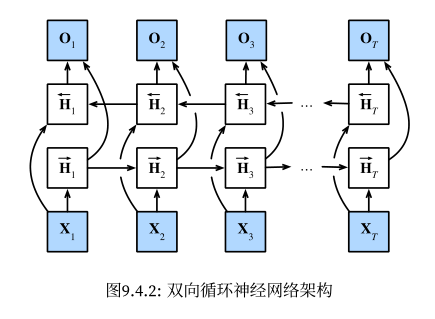
事实上，这与隐⻢尔可夫模型中的动态规划的前向和后向递归没有太⼤区别。其主要区别是，在隐⻢尔可夫
模型中的⽅程具有特定的统计意义。双向循环神经⽹络没有这样容易理解的解释，我们只能把它们当作通⽤
的、可学习的函数。这种转变集中体现了现代深度⽹络的设计原则：⾸先使⽤经典统计模型的函数依赖类型，
然后将其参数化为通⽤形式。
#### 定义
双向循环神经⽹络是由 (Schuster and Paliwal, 1997)提出的，关于各种架构的详细讨论请参阅 (Graves and
Schmidhuber, 2005)。让我们看看这样⼀个⽹络的细节。

对于任意时间步t，给定⼀个⼩批量的输⼊数据 X t ∈ R n×d （样本数n，每个⽰例中的输⼊数d），并且令隐藏
层激活函数为ϕ。在双向架构中，我们设该时间步的前向和反向隐状态分别为
− →
H t ∈ R n×h 和
←−
H t ∈ R n×h ，其
中h是隐藏单元的数⽬。前向和反向隐状态的更新如下：
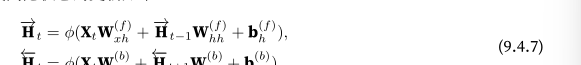
其中，权重W (f)
xh
∈ R d×h ,W (f)
hh
∈ R h×h ,W (b)
xh
∈ R d×h ,W (b)
hh
∈ R h×h 和偏置b (f)
h
∈ R 1×h ,b (b)
h
∈ R 1×h 都是模型
参数。

接下来，将前向隐状态 − → H t 和反向隐状态 ←− H t 连接起来，获得需要送⼊输出层的隐状态H t ∈ R n×2h 。在具有多
个隐藏层的深度双向循环神经⽹络中，该信息作为输⼊传递到下⼀个双向层。最后，输出层计算得到的输出
为 O t ∈ R n×q （q是输出单元的数⽬）：
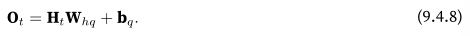
这⾥，权重矩阵W hq ∈ R 2h×q 和偏置b q ∈ R 1×q 是输出层的模型参数。事实上，这两个⽅向可以拥有不同数
量的隐藏单元。
#### 模型的计算代价及其应用
双向循环神经⽹络的⼀个关键特性是：使⽤来⾃序列两端的信息来估计输出。也就是说，我们使⽤来⾃过去
和未来的观测信息来预测当前的观测。但是在对下⼀个词元进⾏预测的情况中，这样的模型并不是我们所需
的。因为在预测下⼀个词元时，我们终究⽆法知道下⼀个词元的下⽂是什么，所以将不会得到很好的精度。
具体地说，在训练期间，我们能够利⽤过去和未来的数据来估计现在空缺的词；⽽在测试期间，我们只有过
去的数据，因此精度将会很差。下⾯的实验将说明这⼀点。

另⼀个严重问题是，双向循环神经⽹络的计算速度⾮常慢。其主要原因是⽹络的前向传播需要在双向层中进
⾏前向和后向递归，并且⽹络的反向传播还依赖于前向传播的结果。因此，梯度求解将有⼀个⾮常⻓的链。
双向层的使⽤在实践中⾮常少，并且仅仅应⽤于部分场合。例如，填充缺失的单词、词元注释（例如，⽤于
命名实体识别）以及作为序列处理流⽔线中的⼀个步骤对序列进⾏编码（例如，⽤于机器翻译）。在 14.8节和
15.2节中，我们将介绍如何使⽤双向循环神经⽹络编码⽂本序列。

### 双向循环神经网络的错误应用
由于双向循环神经⽹络使⽤了过去的和未来的数据，所以我们不能盲⽬地将这⼀语⾔模型应⽤于任何预测任
务。尽管模型产出的困惑度是合理的，该模型预测未来词元的能⼒却可能存在严重缺陷。我们⽤下⾯的⽰例
代码引以为戒，以防在错误的环境中使⽤它们。

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

# 加载数据
batch_size, num_steps, device = 32, 35, d2l.try_gpu()
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)
# 通过设置“bidirective=True”来定义双向LSTM模型
vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers, bidirectional=True)
model = d2l.RNNModel(lstm_layer, vocab_size)
model = model.to(device)
# 训练模型
num_epochs, lr = 500, 1
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

上述结果显然令⼈瞠⽬结⾆。关于如何更有效地使⽤双向循环神经⽹络的讨论，请参阅 15.2节中的情感分类
应⽤。

#### ⼩结

    • 在双向循环神经⽹络中，每个时间步的隐状态由当前时间步的前后数据同时决定。
    • 双向循环神经⽹络与概率图模型中的“前向-后向”算法具有相似性。
    • 双向循环神经⽹络主要⽤于序列编码和给定双向上下⽂的观测估计。
    • 由于梯度链更⻓，因此双向循环神经⽹络的训练代价⾮常⾼。